In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from dataset import Data, ResizeTransform
from gan import GeneratorNet, Discriminator, train
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
from visualize import plot_batch, PlotLossCallback

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/img_align_celeba'
BATCH_SIZE = 512
NUM_WORKERS = 1
Z_SIZE = 100
MODEL_PATH = 'model/'
LOAD_MODEL = False
LOAD_EPOCH_N = 60

In [3]:

transform = ResizeTransform(path='data')
data = Data(DATA_PATH, Z_SIZE, transform)
data_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True)
print('Dataset size: ', len(data))


Dataset size:  202599


In [17]:
df = pd.read_csv('data/list_attr_celeba.txt', sep='\s+', header=1)
print(list(df))
df[['Male', 'Smiling', 'Young', 'Mustache', 'Bald', 'Eyeglasses', 'Wearing_Hat']].head(10)

df_bb = pd.read_csv(str('data/list_bbox_celeba.txt'), sep='\s+', header=1)
df_bb.head()

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [4]:
generator = GeneratorNet(Z_SIZE).cuda()
discriminator = Discriminator().cuda()

In [5]:
print(generator)

GeneratorNet(
  (layer0): Linear(in_features=100, out_features=16384, bias=True)
  (layer1): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [6]:
if LOAD_MODEL:
    generator.load_state_dict(torch.load(MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))

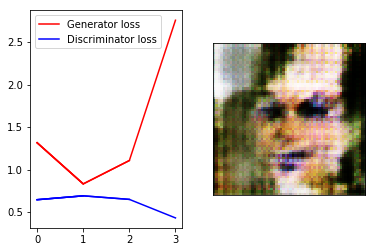

In [ ]:
callback = PlotLossCallback(generator, discriminator)
train(generator, discriminator, data_loader, 100, k=1, callback_func=callback)


In [10]:

#print(Z)

tensor([[ 1.8307, -0.2602, -1.7820, -0.9923,  0.3051,  0.8523,  0.1468,
         -1.6428, -0.1286, -1.1731, -2.5091, -0.4575,  0.1769,  1.3189,
         -1.0830,  0.8586, -0.0031,  1.2339, -0.0026, -0.1130, -1.5624,
          0.8822, -1.2263,  0.4550, -2.0632,  0.4783, -2.7451,  0.9911,
         -0.3107, -1.6872, -0.2557,  0.9607, -0.8107, -0.8012, -2.2284,
          0.0102,  0.7794, -0.9828,  0.3473,  0.4681, -0.7351,  1.0933,
         -0.0636, -0.1289,  1.7876,  0.0795, -1.0996,  1.2146,  0.9892,
         -1.2441,  0.2528, -0.8565,  0.6095,  0.4950,  0.5277, -1.7238,
         -1.8258,  0.3929,  0.0484,  2.5564,  0.4598,  0.0592, -2.5452,
          0.7219, -0.1022,  0.4436, -0.5843, -0.3153, -0.6031, -1.2584,
         -0.1151, -0.2073, -2.2004,  1.5587,  2.2979,  0.5019,  0.4290,
          0.1358,  0.8879, -1.2404, -0.6883,  1.4252,  0.3508, -0.0374,
         -1.9984, -0.3522,  0.2310, -0.4234, -1.9883,  1.9122, -0.9175,
          2.0863,  1.4500, -1.0468, -0.7860,  1.6368, -0.3341,  

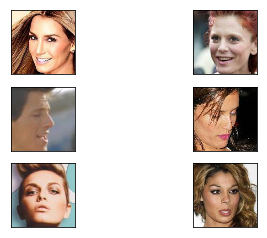

In [8]:
for batch, Z in data_loader:
    plot_batch((batch.data.cpu().numpy() + 1)/2, limit=6)
    break

[[-0.48774287  0.03619685  0.06303496 ...  0.07793363  0.07628664
   0.11514128]]


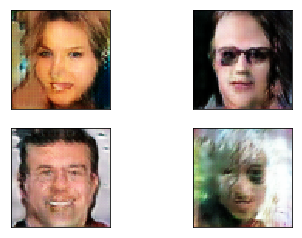

In [17]:
Z = torch.normal(mean=torch.zeros(4, generator.z_size)).cuda()
G_sample = generator(Z)
sample = G_sample.data.cpu().numpy()
print(discriminator.layer4.weight.cpu().detach().numpy())
plot_batch((G_sample.data.cpu().numpy() + 1) / 2)

In [11]:
w = generator.layer3[0].weight.data.cpu().numpy()
print(w)

[[[[ 0.02458958 -0.06051933  0.00292836]
   [-0.00494211 -0.01545624  0.06030454]
   [-0.03969005 -0.03409474  0.00231405]]

  [[-0.04422877 -0.06876548 -0.11997803]
   [ 0.03309397 -0.00818911 -0.04802961]
   [ 0.00893284  0.027688   -0.09394128]]

  [[ 0.0861331   0.00800889  0.00124623]
   [ 0.05027046 -0.03069095  0.00118374]
   [ 0.03100282 -0.00630954 -0.04032575]]

  ...

  [[-0.03772606 -0.11972412 -0.08509952]
   [-0.1038816   0.00960982 -0.06793642]
   [-0.02317528 -0.00824684 -0.017847  ]]

  [[-0.00706451 -0.01054856 -0.01096817]
   [ 0.03456292 -0.04145178 -0.04362727]
   [ 0.01692968 -0.02994676  0.00869299]]

  [[-0.03001426 -0.06845455 -0.00093416]
   [ 0.02326648  0.02071085 -0.06684013]
   [ 0.01425308 -0.01339746 -0.01259475]]]


 [[[-0.03293097 -0.01227505 -0.0092974 ]
   [-0.05402784 -0.03573897 -0.02609124]
   [-0.01960739 -0.00850231 -0.04796467]]

  [[-0.0376382   0.02970959 -0.03291143]
   [-0.01474006  0.00076789 -0.02962288]
   [-0.05800799 -0.02692418 -0.044

In [ ]:
for batch, Z in data_loader:
    X = batch.cuda()
    Z = Z.cuda()
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(X)
    D_fake, D_logit_fake = discriminator(G_sample)
    print('D_real', D_real,'\n', 'D_fake', D_fake)
    print('D_logit_real', D_logit_real, '\n', 'D_logit_fake', D_logit_fake)
    break
    